In [3]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
import random
import pickle
import cv2
from copy import copy
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, Manager
import pyarrow.parquet as pq

import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

<h1> Load Base Data </h1>

In [4]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null and b.is_qa = false;
"""
df = rds_access_utils.extract_from_database(query)

In [5]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
def centroid_depth(x):
    if x:
        return np.mean([w[1] for w in x.values()])
    return None

def eye_depth(x):
    if x:
        return x['EYE'][1]
    return None
    
df['world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)

df['depth'] = df.world_keypoints.apply(lambda x: centroid_depth(x))
df['eye_depth'] = df.world_keypoints.apply(lambda x: eye_depth(x))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


<h1> Load Parquet data from PySpark template matching service output files in s3 </h1>

In [6]:
s3_access_utils = S3AccessUtils('/root/data')

In [7]:
gen = s3_access_utils.get_matching_s3_keys('aquabyte-research', prefix='template-matching/2019-11-01T19:26', suffixes=['.parquet'])
keys = []
for key in gen:
    keys.append(key)

f = s3_access_utils.download_from_s3('aquabyte-research', keys[0])
pdf = pd.read_parquet(f)


<h1> Join with existing base data and clean up template matching output columns </h1>

In [8]:
pdf['homography'] = pdf.homography_and_matches.apply(lambda x: np.array(x[0].tolist(), dtype=np.float))
pdf['matches'] = pdf.homography_and_matches.apply(lambda x: np.array(x[1].tolist(), dtype=np.int) if len(x) > 1 else None)



In [9]:
def get_fish_distance_from_camera(matches, cm):
    distances = []
    for idx in range(len(matches)):
        x1, y1, x2, y2 = matches[idx]
        disp = abs(x1 - x2)
        dist = depth_from_disp(disp, cm)
        distances.append(dist)
    return np.mean(dist)

        
        

In [10]:
fish_distances = []
row_count = 0
for idx, row in pdf.iterrows():
    matches = row.matches
    cm = json.loads(row.camera_metadata)
    if matches is not None:
        fish_distance = get_fish_distance_from_camera(matches, cm)
        fish_distances.append(fish_distance)
    else:
        fish_distances.append(None)
    if row_count % 100 == 0:
        print(row_count)
    row_count += 1
    
        

    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900


In [11]:
pdf['fish_distance'] = fish_distances

<h1> Plot fish distance districution against previously calcualted fish distnace distribution to ensure that they are mostly consistent with each other </h1>

<h2> Fish distance distribution based on template matching body keypoints </h2>

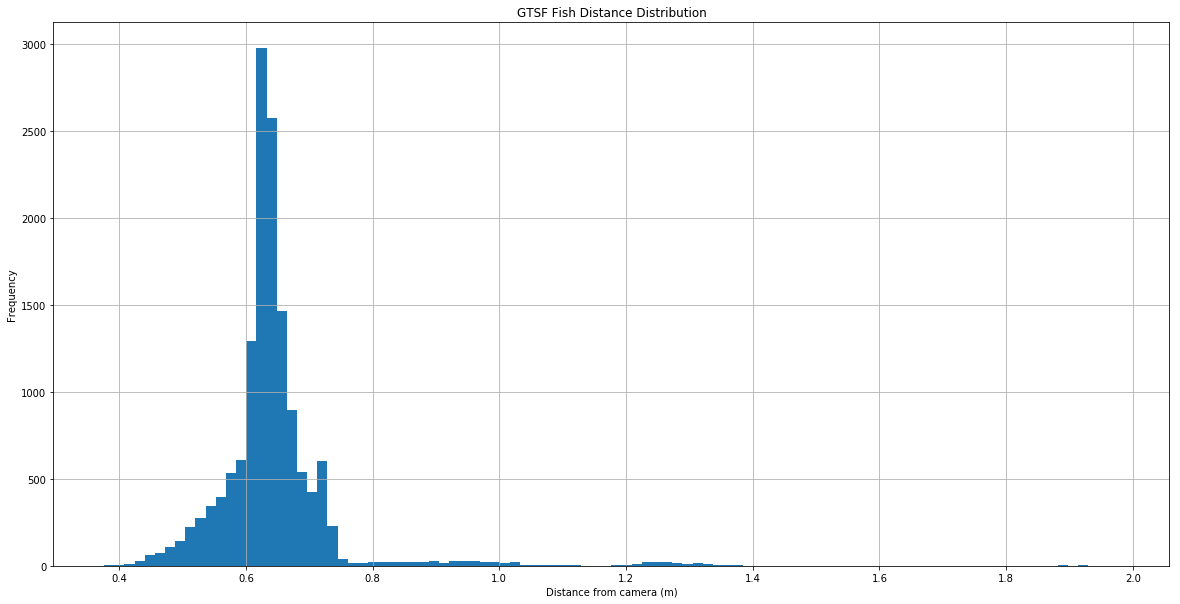

In [12]:
plt.figure(figsize=(20, 10))
mask = pdf.fish_distance < 2.0
plt.hist(pdf[mask].fish_distance, bins=100)
plt.title('GTSF Fish Distance Distribution')
plt.xlabel('Distance from camera (m)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

<h2> Fish distance distribution based on keypoint centroid </h2>

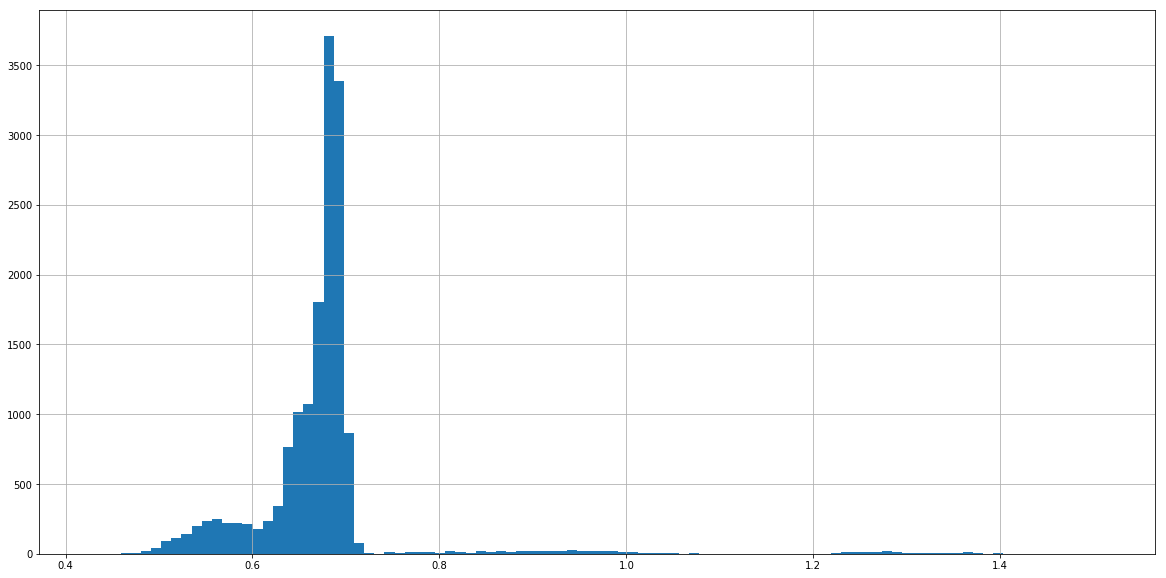

In [73]:
plt.figure(figsize=(20, 10))
mask = (df.depth > 0) & (df.depth < 2)
plt.hist(df[mask].depth, bins=100)
plt.grid()
plt.show()

In [79]:
x = pdf.matches.iloc[0]
np.median(np.abs(x[:, 1] - x[:, 3]))

1.0

<h2> Fish distance distribution based on annotated eye </h2>

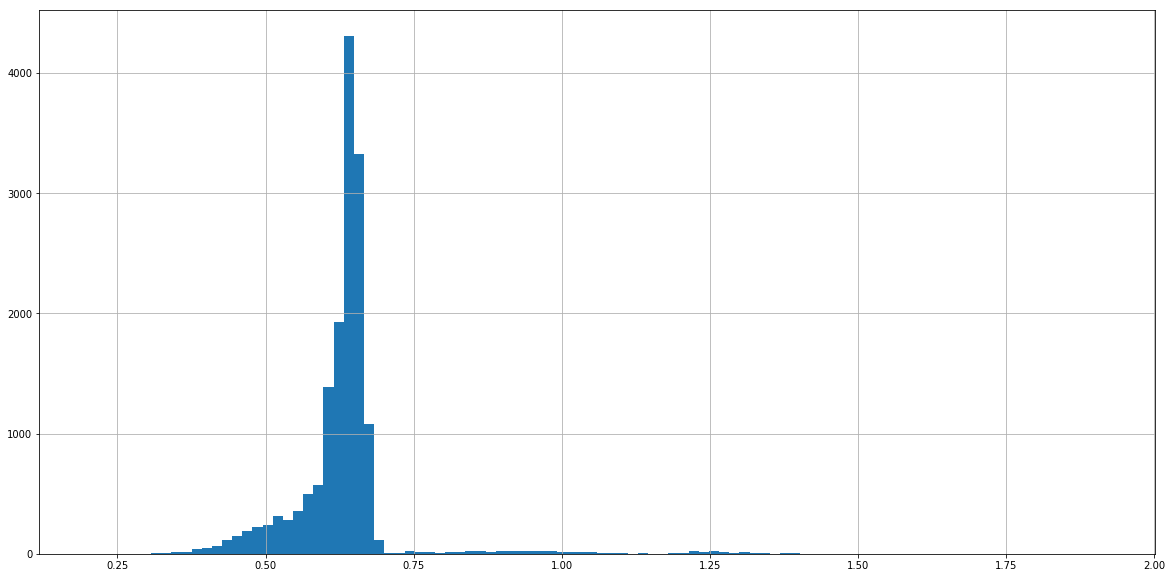

In [83]:
plt.figure(figsize=(20, 10))
mask = (df.eye_depth > 0) & (df.eye_depth < 2)
plt.hist(df[mask].eye_depth, bins=100)
plt.grid()
plt.show()